In [1]:
!pip install fancyimpute mrmr-selection skfeature-chappers missingno mlxtend xgboost

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.4 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=b3650eb12fb0160c40a7c83d29ecc6c8534994dda9675f67136829e0fb974fe4
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=05ba5dcb9456bb9b7939220a933295830cc7cb482111abf998e92d26f7f1f366
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LogisticRegression, LassoCV, LinearRegression
from sklearn.feature_selection import mutual_info_classif, chi2, RFE
from mlxtend.feature_selection import SequentialFeatureSelector
from mrmr import mrmr_classif
from fancyimpute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer


import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [3]:
# Open and load the file from Drive
directory = '/content/drive/MyDrive/Colab Notebooks/Project/'
file_path = directory + 'Book2.csv'
with open(file_path) as f:
    data = pd.read_csv(f)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Columns: 188 entries, Samples to Val
dtypes: float64(185), int64(1), object(2)
memory usage: 138.2+ KB


,Samples,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,15298,Prostate cancer,AA,84.85,2.26,1.635,27.75,19.85,34.75,1.69,...,383.5,32.5,127.0,96.5,272.0,131.0,226.0,75.9,90.05,255.0
1,17585,Prostate cancer,EA,87.40,3.18,1.330,23.70,14.20,20.10,2.76,...,252.0,26.1,118.0,94.6,253.0,79.6,146.0,80.7,105.00,294.0
2,17848,Case control,EA,157.00,7.33,3.250,43.10,43.10,92.30,3.51,...,402.0,58.9,196.0,141.0,454.0,218.0,341.0,86.1,151.00,302.0
3,17893,Case control,EA,59.30,1.86,1.270,18.40,11.30,13.80,1.16,...,328.0,30.9,124.0,93.0,365.0,131.0,215.0,94.1,101.00,391.0
4,17962,Case control,EA,57.80,1.78,0.781,18.00,12.10,13.20,1.48,...,98.8,13.4,57.9,39.6,130.0,41.5,58.5,27.2,35.80,115.0


In [4]:
df = data.copy()

# shuffling the df
shuffled_df = shuffle(df, random_state=42)

# Encoding catergorical data to numerical data
df['Race'] = df['Race'].map({'EA': 0, 'AA': 1})
df['Status'] = df['Status'].map({'Case control': 0, 'Prostate cancer': 1})

df.head()


,Samples,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,15298,1,1,84.85,2.26,1.635,27.75,19.85,34.75,1.69,...,383.5,32.5,127.0,96.5,272.0,131.0,226.0,75.9,90.05,255.0
1,17585,1,0,87.40,3.18,1.330,23.70,14.20,20.10,2.76,...,252.0,26.1,118.0,94.6,253.0,79.6,146.0,80.7,105.00,294.0
2,17848,0,0,157.00,7.33,3.250,43.10,43.10,92.30,3.51,...,402.0,58.9,196.0,141.0,454.0,218.0,341.0,86.1,151.00,302.0
3,17893,0,0,59.30,1.86,1.270,18.40,11.30,13.80,1.16,...,328.0,30.9,124.0,93.0,365.0,131.0,215.0,94.1,101.00,391.0
4,17962,0,0,57.80,1.78,0.781,18.00,12.10,13.20,1.48,...,98.8,13.4,57.9,39.6,130.0,41.5,58.5,27.2,35.80,115.0


In [5]:
# Check for NaN values
nan_check = df.isna().sum()
print(nan_check[nan_check > 0])

# Check total number of NaN values in df
total_nan = df.isna().sum().sum()
print("Total number of NaN values in the DataFrame (Before):", total_nan)

df.tail(10)

PC aa C34:4    1
PC aa C36:0    1
PC aa C36:1    1
PC aa C36:2    1
PC aa C36:3    1
              ..
Ser            1
Thr            2
Trp            1
Tyr            1
Val            1
Length: 160, dtype: int64
Total number of NaN values in the DataFrame (Before): 170


,Samples,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
84,20049,0,1,63.0,1.93,0.918,19.30,13.20,29.7,1.95,...,229.0,36.7,84.3,98.5,325.0,143.0,221.0,68.8,129.0,368.0
85,20051,0,1,90.3,2.41,1.470,26.10,14.80,22.3,1.79,...,307.0,40.1,123.0,82.7,209.0,134.0,167.0,81.1,101.0,340.0
86,20070,0,1,74.0,2.26,0.933,20.70,15.00,17.2,1.43,...,248.0,33.6,56.5,69.8,219.0,103.0,135.0,47.8,87.0,243.0
87,20078,0,1,109.5,2.36,1.635,35.75,16.85,24.7,1.87,...,108.0,10.5,65.0,37.2,65.4,50.6,NaN,23.5,31.7,107.0
88,20099,0,1,118.0,3.68,2.090,32.30,19.50,27.8,2.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,20103,0,1,137.0,3.00,2.390,47.20,23.50,41.5,2.44,...,207.0,22.9,99.1,68.5,200.0,98.0,111.0,60.4,63.1,213.0
90,20319,0,1,182.0,4.81,2.470,52.60,27.80,46.2,2.81,...,389.0,49.3,201.0,158.0,514.0,136.0,204.0,108.0,140.0,495.0
91,20323,0,1,150.0,3.46,2.260,55.00,29.70,61.0,3.81,...,312.0,29.5,143.0,117.0,330.0,94.6,155.0,87.4,75.2,348.0
92,20361,0,1,133.0,2.74,2.130,45.00,19.80,39.9,2.46,...,300.0,35.0,151.0,87.1,510.0,163.0,247.0,73.0,105.0,324.0
93,20752,0,1,212.0,6.19,2.730,55.10,30.60,40.8,3.61,...,355.0,27.9,170.0,113.0,328.0,153.0,187.0,84.3,86.6,450.0


In [6]:
df = df.drop(columns=['Samples'])

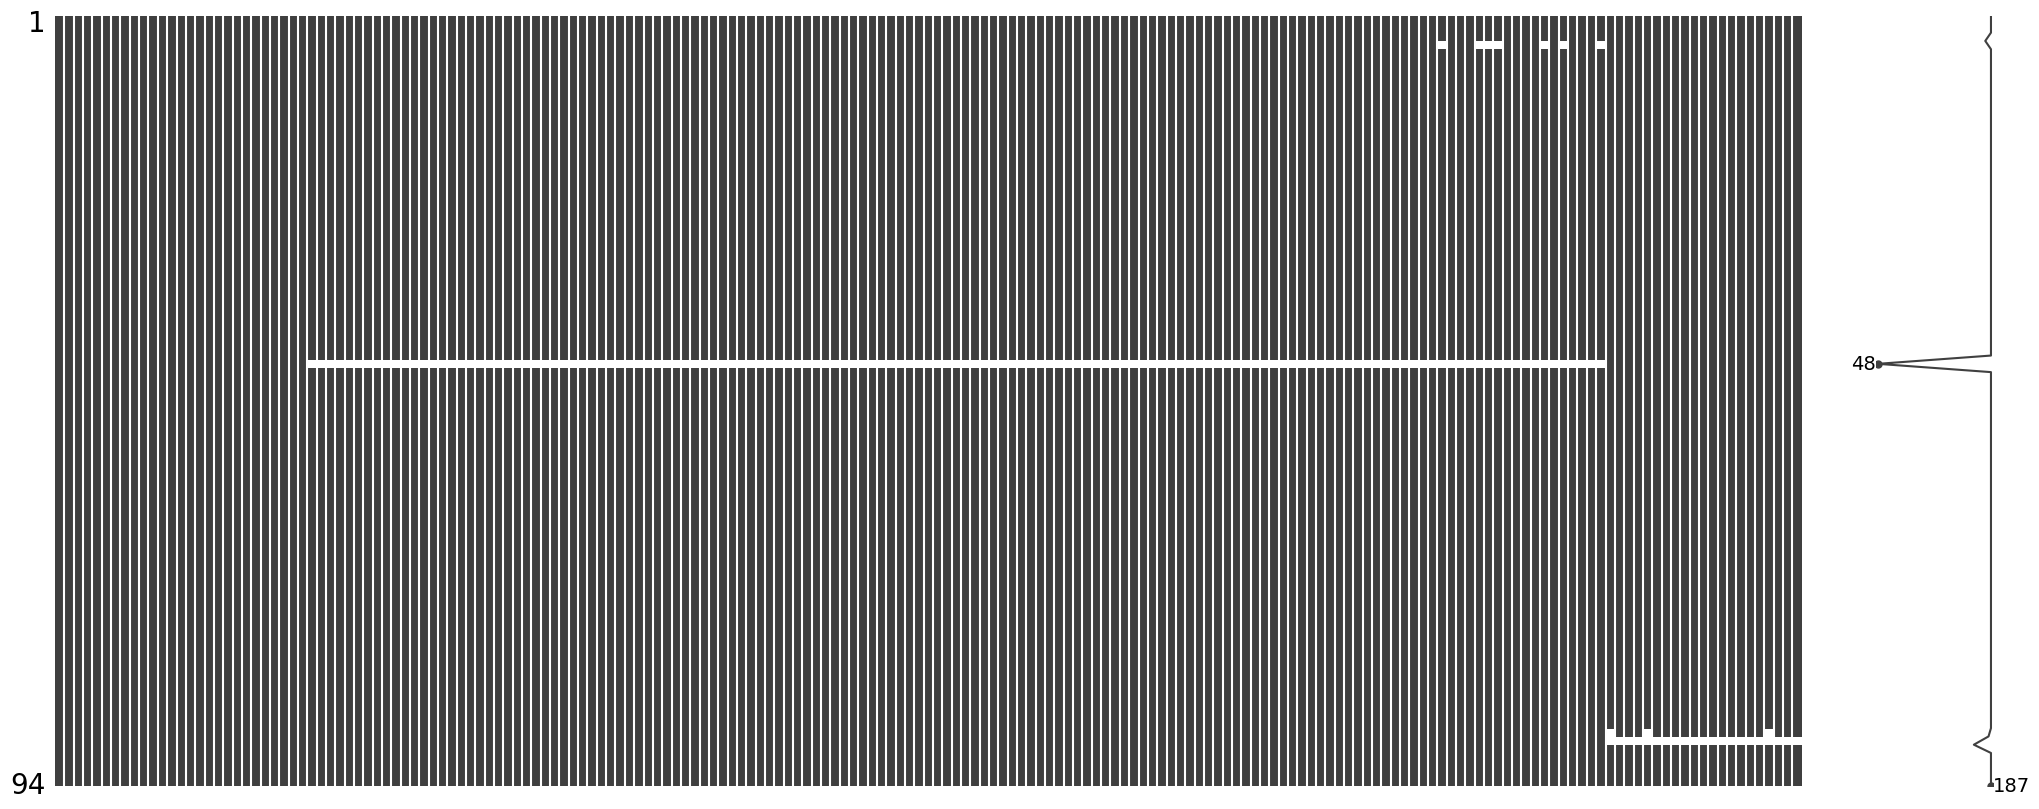

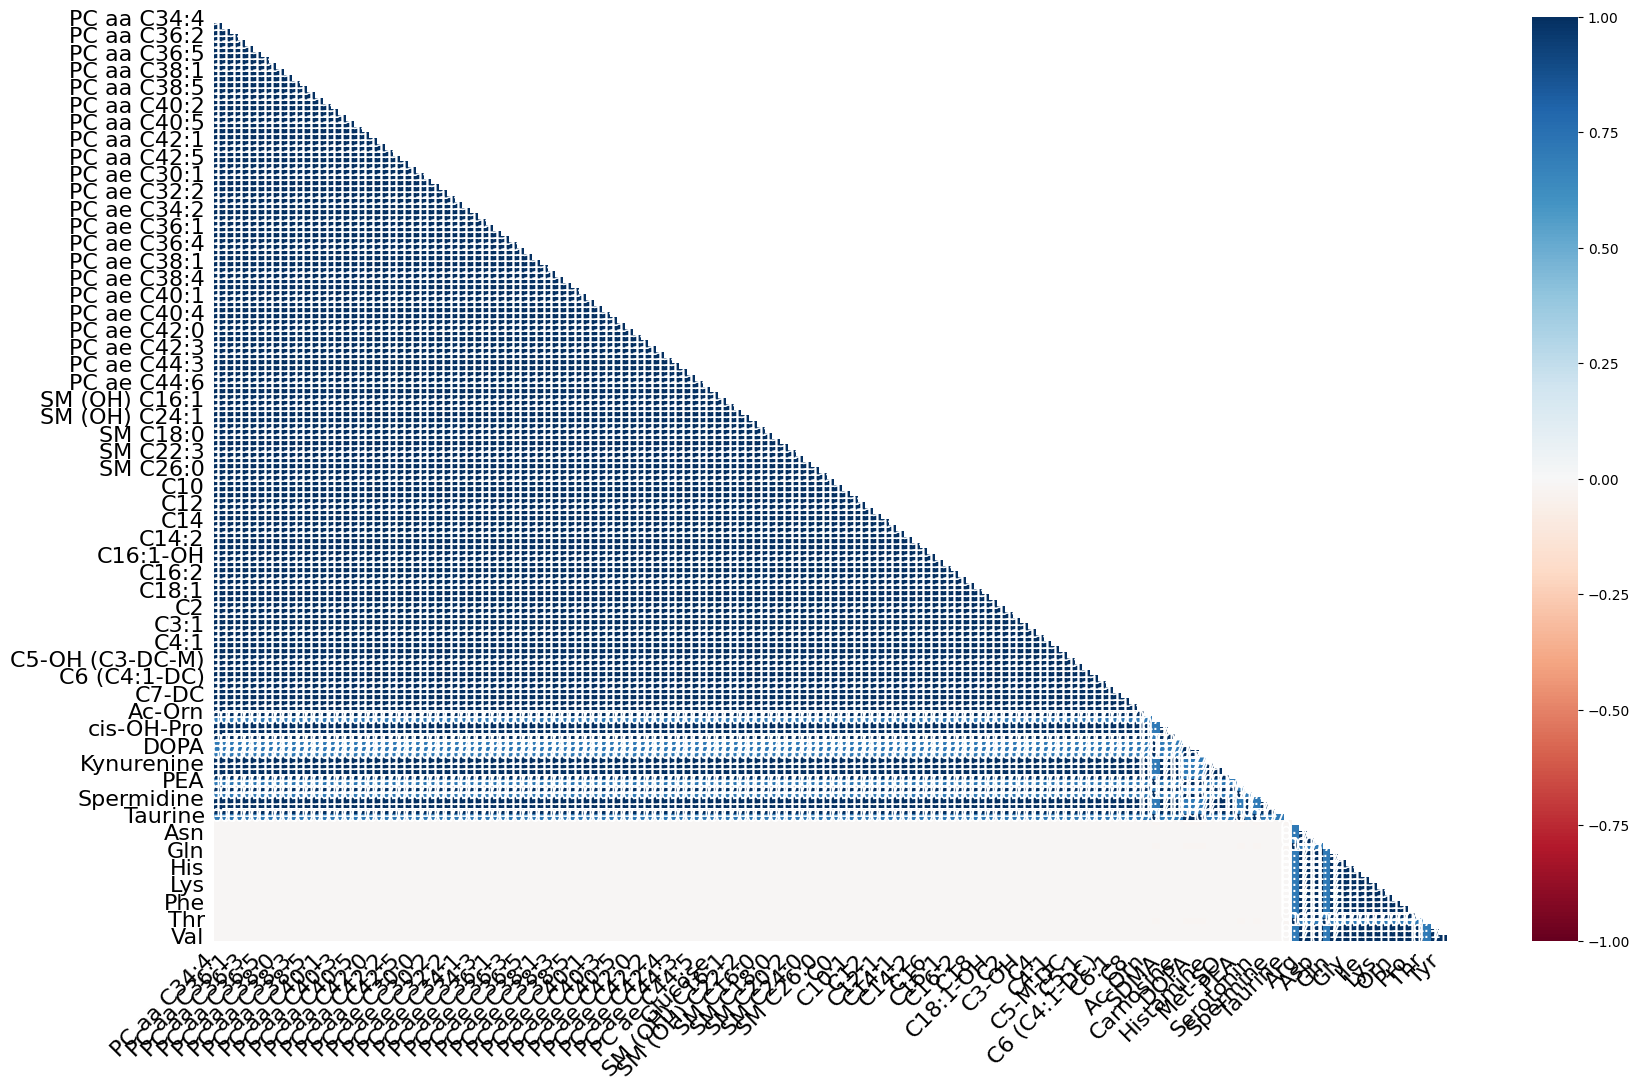

In [7]:
# Visualize missing data pattern
msno.matrix(df)
plt.show()

# Check for any particular patterns in missing data
msno.heatmap(df)
plt.show()


In [8]:
# Split data into train (80%) and test (20%)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=43)

# # Remove some values from the training data for testing imputation
train_data_with_missing = train_data.copy()
# train_data_with_missing.iloc[::10, :] = pd.NA

# Specify the columns to exclude from missing values
columns_to_exclude = ['Status', 'Race']

# Get the list of columns where missing values will be introduced
columns_to_modify = train_data_with_missing.columns.difference(columns_to_exclude)

# Introduce missing values only in the selected columns
train_data_with_missing.loc[::10, columns_to_modify] = pd.NA


In [9]:
train_data_with_missing.tail(20)

,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
4,0,0,57.8,1.78,0.781,18.0,12.1,13.2,1.48,5.43,...,98.8,13.4,57.9,39.6,130.0,41.5,58.5,27.2,35.8,115.0
84,0,1,63.0,1.93,0.918,19.3,13.2,29.7,1.95,6.61,...,229.0,36.7,84.3,98.5,325.0,143.0,221.0,68.8,129.0,368.0
79,1,1,99.4,2.52,2.920,29.3,17.1,20.4,1.80,6.73,...,345.0,46.0,100.0,127.0,276.0,145.0,193.0,88.7,138.0,374.0
34,0,0,99.1,2.84,1.680,26.9,24.7,47.8,1.94,11.90,...,296.0,37.5,171.0,96.4,320.0,140.0,205.0,91.7,80.2,298.0
65,1,0,165.0,4.64,3.030,51.0,32.3,43.5,2.79,8.40,...,238.0,29.0,109.0,84.1,235.0,117.0,158.0,121.0,90.2,308.0
75,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,0,1,114.0,2.75,1.240,30.3,22.2,34.5,2.26,9.99,...,251.0,45.5,136.0,104.0,395.0,119.0,182.0,70.2,103.0,409.0
35,0,1,99.9,3.52,1.740,33.3,26.1,31.4,1.83,9.00,...,331.0,46.8,131.0,114.0,327.0,164.0,236.0,87.9,132.0,381.0
92,0,1,133.0,2.74,2.130,45.0,19.8,39.9,2.46,11.40,...,300.0,35.0,151.0,87.1,510.0,163.0,247.0,73.0,105.0,324.0
30,0,0,124.0,3.51,2.570,37.5,22.7,30.9,1.39,5.53,...,337.0,31.4,168.0,88.8,436.0,169.0,179.0,75.4,94.7,299.0


In [10]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


#NaN Value Treatment

# MICE (Linear)

In [11]:
# # MICE (Linear)
# mice_linear_imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=42)
# df_linear_imputed = mice_linear_imputer.fit_transform(train_data_with_missing)

In [12]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np


# Define the imputer and dummy regression model pipeline
imputer = IterativeImputer(estimator=LinearRegression(n_jobs=-1), random_state=42)

# Set up hyperparameter grid for GridSearchCV
param_grid_linear = {
    'imputer__max_iter': [5, 10, 20],  # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],      # Convergence tolerance
    'imputer__initial_strategy': ['median'],  # Strategy for initializing missing values
    'imputer__n_nearest_features': [None, 5, 10],     # Number of nearest features
}

# Use a pipeline to apply the imputer followed by a dummy regressor (as a placeholder for scoring)
pipeline_linear = Pipeline(steps=[('imputer', imputer)])

# Set up GridSearchCV with a custom scorer (e.g., mean squared error)
# Use GridSearchCV with built-in scoring like neg_mean_squared_error, neg_mean_absolute_error, or r2
grid_search_linear = GridSearchCV(estimator=pipeline_linear, param_grid=param_grid_linear, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)

# Fit GridSearchCV to your data to find the best imputer configuration
grid_search_linear.fit(train_data_with_missing)

# Get the best imputer configuration and re-fit it on the entire data
best_linear_imputer = grid_search_linear.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_linear_imputed = best_linear_imputer.fit_transform(train_data_with_missing)


#Correlation-Based Imputation

In [13]:
# Function for Correlation-Based Imputation
def correlation_based_imputation(df):
    for column in df.columns:
        # Check if there are missing values in the column
        if df[column].isnull().sum() > 0:

            # Find the most correlated feature with the current column
            correlated_feature = df.corr()[column].dropna().idxmax()
            # print(f"Imputing {column} using {correlated_feature}")

            # Impute missing values in the correlated feature using mean (or other methods)
            df[correlated_feature].fillna(df[correlated_feature].mean(), inplace=True)

            # Train linear regression model on non-missing rows
            non_missing_rows = df[df[column].notnull()]
            model = LinearRegression()
            model.fit(non_missing_rows[[correlated_feature]], non_missing_rows[column])

            # Predict missing values for rows where the current column has NaNs
            missing_rows = df[df[column].isnull()]
            if not missing_rows.empty:
                predicted_values = model.predict(missing_rows[[correlated_feature]])
                df.loc[df[column].isnull(), column] = predicted_values
    return df

df_corr_imputed = correlation_based_imputation(train_data_with_missing)


# PMM Imputation

In [14]:
# PMM Imputation
pmm_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=43, imputation_order='random')
df_pmm_imputed = pmm_imputer.fit_transform(train_data_with_missing)
df_pmm_imputed = pd.DataFrame(df_pmm_imputed, columns=train_data_with_missing.columns)
df_pmm_imputed.head()

,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,0.0,0.0,116.126866,3.608209,2.766522,35.252239,22.519403,33.685821,2.747522,9.314552,...,289.443939,34.92803,128.568939,98.131818,314.557576,128.49697,178.410606,80.147727,103.098485,320.371212
1,0.0,1.0,218.000000,7.410000,33.300000,107.000000,24.900000,29.600000,12.500000,11.100000,...,296.000000,50.20000,112.000000,129.000000,409.000000,168.00000,202.000000,92.800000,143.000000,356.000000
2,0.0,0.0,127.000000,4.090000,2.440000,33.700000,23.900000,41.900000,2.140000,6.060000,...,275.000000,23.20000,147.000000,90.200000,316.000000,84.80000,116.000000,72.300000,75.800000,283.000000
3,1.0,1.0,86.200000,2.360000,1.790000,28.100000,20.000000,40.800000,1.950000,9.070000,...,226.000000,30.00000,91.300000,79.500000,286.000000,127.00000,167.000000,54.300000,86.700000,294.000000
4,0.0,1.0,118.000000,3.680000,2.090000,32.300000,19.500000,27.800000,2.450000,8.500000,...,289.443939,34.92803,128.568939,98.131818,314.557576,128.49697,178.410606,80.147727,103.098485,320.371212


# KNN

In [15]:
# # KNN
# mice_knn_imputer = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5, weights='uniform'), max_iter=10, random_state=0)
# df_knn_imputed = mice_knn_imputer.fit_transform(train_data_with_missing)


In [16]:
# KNN

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error

# Define the KNN-based imputer with an initial KNeighborsRegressor
imputer_knn = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5, weights='uniform',n_jobs=-1), random_state=42)

# Set up hyperparameter grid for KNN-based imputation in GridSearchCV
param_grid_knn = {
    'imputer__max_iter': [5, 10, 20],                   # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],                       # Convergence tolerance
    'imputer__initial_strategy': ['median'],    # Initial strategy for missing values
    'imputer__n_nearest_features': [None, 5, 10],       # Number of nearest features to consider
    'imputer__estimator__n_neighbors': [3, 5, 7],       # Number of neighbors for KNN
    'imputer__estimator__weights': ['uniform', 'distance'],  # Weighting strategy for KNN
}

# Use a pipeline for the imputer followed by a dummy regressor (as a placeholder for scoring)
pipeline_knn = Pipeline(steps=[('imputer', imputer_knn)])

# Set up GridSearchCV with built-in scoring (neg_mean_squared_error)
grid_search_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to your data to find the best KNN-based imputer configuration
grid_search_knn.fit(train_data_with_missing)

# Get the best KNN-based imputer configuration and re-fit it on the entire data
best_knn_imputer = grid_search_knn.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_knn_imputed = best_knn_imputer.fit_transform(train_data_with_missing)


# Ridgde

In [17]:
# # Ridgde
# mice_ridge_imputer = IterativeImputer(estimator=Ridge(alpha=1.0), max_iter=10, random_state=42)
# df_ridge_imputed = mice_ridge_imputer.fit_transform(train_data_with_missing)


In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error

# Define the Ridge-based imputer with an initial Ridge estimator
imputer_ridge = IterativeImputer(estimator=Ridge(alpha=1.0), random_state=42)

# Set up hyperparameter grid for Ridge-based imputation in GridSearchCV
param_grid_ridge = {
    'imputer__max_iter': [5, 10, 20],                   # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],                       # Convergence tolerance
    'imputer__initial_strategy': ['median'],    # Initial strategy for missing values
    'imputer__n_nearest_features': [None, 5, 10],       # Number of nearest features to consider
    'imputer__estimator__alpha': [0.1, 1.0, 10.0],      # Regularization strength for Ridge
}

# Use a pipeline for the imputer followed by a dummy regressor (as a placeholder for scoring)
pipeline_ridge = Pipeline(steps=[('imputer', imputer_ridge)])

# Set up GridSearchCV with built-in scoring (neg_mean_squared_error)
grid_search_ridge = GridSearchCV(estimator=pipeline_ridge, param_grid=param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to your data to find the best Ridge-based imputer configuration
grid_search_ridge.fit(train_data_with_missing)

# Get the best Ridge-based imputer configuration and re-fit it on the entire data
best_ridge_imputer = grid_search_ridge.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_ridge_imputed = best_ridge_imputer.fit_transform(train_data_with_missing)


# Lasso

In [19]:
# # Lasso
# mice_lasso_imputer = IterativeImputer(estimator=Lasso(alpha=0.1), max_iter=10, random_state=42)
# df_lasso_imputed = mice_lasso_imputer.fit_transform(train_data_with_missing)


In [20]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error

# Define the Lasso-based imputer with an initial Lasso estimator
imputer_lasso = IterativeImputer(estimator=Lasso(alpha=0.1), random_state=42)

# Set up hyperparameter grid for Lasso-based imputation in GridSearchCV
param_grid_lasso = {
    'imputer__max_iter': [5, 10, 20],                   # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],                       # Convergence tolerance
    'imputer__initial_strategy': ['median'],    # Initial strategy for missing values
    'imputer__n_nearest_features': [None, 5, 10],       # Number of nearest features to consider
    'imputer__estimator__alpha': [0.01, 0.1, 1.0],      # Regularization strength for Lasso
    'imputer__estimator__fit_intercept': [True, False]  # Whether to fit the intercept in Lasso
}

# Use a pipeline for the imputer followed by a dummy regressor (as a placeholder for scoring)
pipeline_lasso = Pipeline(steps=[('imputer', imputer_lasso)])

# Set up GridSearchCV with built-in scoring (neg_mean_squared_error)
grid_search_lasso = GridSearchCV(estimator=pipeline_lasso, param_grid=param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to your data to find the best Lasso-based imputer configuration
grid_search_lasso.fit(train_data_with_missing)

# Get the best Lasso-based imputer configuration and re-fit it on the entire data
best_lasso_imputer = grid_search_lasso.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_lasso_imputed = best_lasso_imputer.fit_transform(train_data_with_missing)


# ElasticNet

In [21]:
# # ElasticNet
# mice_elasticnet_imputer = IterativeImputer(estimator=ElasticNet(alpha=1.0, l1_ratio=0.5), max_iter=10, random_state=42)
# df_elasticnet_imputed = mice_elasticnet_imputer.fit_transform(train_data_with_missing)


In [22]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error

# Define the ElasticNet-based imputer with an initial ElasticNet estimator
imputer_elasticnet = IterativeImputer(estimator=ElasticNet(alpha=1.0, l1_ratio=0.5), random_state=42)

# Set up hyperparameter grid for ElasticNet-based imputation in GridSearchCV
param_grid_elasticnet = {
    'imputer__max_iter': [5, 10, 20],                      # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],                          # Convergence tolerance
    'imputer__initial_strategy': ['median'],       # Initial strategy for missing values
    'imputer__n_nearest_features': [None, 5, 10],          # Number of nearest features to consider
    'imputer__estimator__alpha': [0.01, 0.1, 1.0],         # Regularization strength for ElasticNet
    'imputer__estimator__l1_ratio': [0.1, 0.5, 0.9],       # Balance between L1 and L2 regularization
}

# Use a pipeline for the imputer followed by a dummy regressor (as a placeholder for scoring)
pipeline_elasticnet = Pipeline(steps=[('imputer', imputer_elasticnet)])

# Set up GridSearchCV with built-in scoring (neg_mean_squared_error)
grid_search_elasticnet = GridSearchCV(estimator=pipeline_elasticnet, param_grid=param_grid_elasticnet, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)

# Fit GridSearchCV to your data to find the best ElasticNet-based imputer configuration
grid_search_elasticnet.fit(train_data_with_missing)

# Get the best ElasticNet-based imputer configuration and re-fit it on the entire data
best_elasticnet_imputer = grid_search_elasticnet.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_elasticnet_imputed = best_elasticnet_imputer.fit_transform(train_data_with_missing)



# XGBRegressor

In [23]:
# # XGBRegressor
# mice_xgb_imputer = IterativeImputer(estimator=XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3), max_iter=10, random_state=42)
# df_xgb_imputed = mice_xgb_imputer.fit_transform(train_data_with_missing)


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

imputer_xgb = IterativeImputer(
    estimator=XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        # tree_method='gpu_hist'  # Enable GPU support
        n_jobs=-1
    ),
    random_state=42
)

# Set up hyperparameter grid for XGBRegressor-based imputation in GridSearchCV
param_grid_xgb = {
    'imputer__max_iter': [5, 10, 20],                          # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],                              # Convergence tolerance
    'imputer__initial_strategy': ['median'],                   # Initial strategy for missing values
    'imputer__n_nearest_features': [None, 5, 10],              # Number of nearest features to consider
    'imputer__estimator__n_estimators': [50, 100, 200],        # Number of trees in the ensemble
    'imputer__estimator__learning_rate': [0.01, 0.1, 0.3],     # Step size shrinkage
    'imputer__estimator__max_depth': [3, 5, 7],                 # Maximum depth of a tree
    'imputer__estimator__subsample': [0.8, 1.0],                # Proportion of samples used for fitting the individual trees
}

# Use a pipeline for the imputer
pipeline_xgb = Pipeline(steps=[('imputer', imputer_xgb)])


# Set up GridSearchCV with built-in scoring (neg_mean_squared_error)
grid_search_xgb = GridSearchCV(estimator=pipeline_xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to your data to find the best XGBRegressor-based imputer configuration
grid_search_xgb.fit(train_data_with_missing)

# Get the best XGBRegressor-based imputer configuration and re-fit it on the entire data
best_xgb_imputer = grid_search_xgb.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_xgb_imputed = best_xgb_imputer.fit_transform(train_data_with_missing)



# SVR

In [ ]:
# # SVR
# mice_svr_imputer = IterativeImputer(estimator=SVR(C=1.0, epsilon=0.1), max_iter=10, random_state=42)
# df_svr_imputed = mice_svr_imputer.fit_transform(train_data_with_missing)


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the SVR-based imputer with an initial SVR estimator
imputer_svr = IterativeImputer(estimator=SVR(C=1.0, epsilon=0.1, n_jobs=-1), random_state=42)

# Set up hyperparameter grid for SVR-based imputation in GridSearchCV
param_grid_svr = {
    'imputer__max_iter': [5, 10, 20],                            # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],                                # Convergence tolerance
    'imputer__initial_strategy': ['median'],             # Initial strategy for missing values
    'imputer__n_nearest_features': [None, 5, 10],                # Number of nearest features to consider
    'imputer__estimator__C': [0.1, 1.0, 10.0],                   # Regularization parameter
    'imputer__estimator__epsilon': [0.01, 0.1, 0.5],             # Epsilon in the epsilon-SVR
    'imputer__estimator__kernel': ['linear', 'rbf'],              # Kernel type to be used in the algorithm
}

# Use a pipeline for the imputer
pipeline_svr = Pipeline(steps=[('imputer', imputer_svr)])

# Set up GridSearchCV with built-in scoring (neg_mean_squared_error)
grid_search_svr = GridSearchCV(estimator=pipeline_svr, param_grid=param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to your data to find the best SVR-based imputer configuration
grid_search_svr.fit(train_data_with_missing)

# Get the best SVR-based imputer configuration and re-fit it on the entire data
best_svr_imputer = grid_search_svr.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_svr_imputed = best_svr_imputer.fit_transform(train_data_with_missing)



# BayesianRidge

In [ ]:
# # BayesianRidge
# mice_bayesianridge_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
# df_bayesianridge_imputed = mice_bayesianridge_imputer.fit_transform(train_data_with_missing)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the Bayesian Ridge-based imputer
imputer_bayesianridge = IterativeImputer(estimator=BayesianRidge(n_jobs=-1), random_state=42)

# Set up hyperparameter grid for Bayesian Ridge imputation in GridSearchCV
param_grid_bayesianridge = {
    'imputer__max_iter': [5, 10, 20],                             # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],                                 # Convergence tolerance
    'imputer__initial_strategy': ['median'],              # Initial strategy for missing values
    'imputer__n_nearest_features': [None, 5, 10],                 # Number of nearest features to consider
    'imputer__estimator__alpha_1': [1e-6, 1e-5, 1e-4],           # Prior for the weight variance
    'imputer__estimator__alpha_2': [1e-6, 1e-5, 1e-4],           # Prior for the noise variance
    'imputer__estimator__lambda_1': [1e-6, 1e-5, 1e-4],         # Prior for the weight variance
    'imputer__estimator__lambda_2': [1e-6, 1e-5, 1e-4],         # Prior for the noise variance
}

# Use a pipeline for the imputer
pipeline_bayesianridge = Pipeline(steps=[('imputer', imputer_bayesianridge)])

# Set up GridSearchCV with built-in scoring (neg_mean_squared_error)
grid_search_bayesianridge = GridSearchCV(estimator=pipeline_bayesianridge, param_grid=param_grid_bayesianridge, cv=5, scoring='neg_mean_squared_error',  n_jobs=-1)

# Fit GridSearchCV to your data to find the best Bayesian Ridge-based imputer configuration
grid_search_bayesianridge.fit(train_data_with_missing)

# Get the best Bayesian Ridge-based imputer configuration and re-fit it on the entire data
best_bayesianridge_imputer = grid_search_bayesianridge.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_bayesianridge_imputed = best_bayesianridge_imputer.fit_transform(train_data_with_missing)



# DecisionTreeRegressor

In [ ]:
# # DecisionTreeRegressor
# mice_tree_imputer = IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5), max_iter=10, random_state=42)
# df_tree_imputed = mice_tree_imputer.fit_transform(train_data_with_missing)


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the Decision Tree-based imputer
imputer_tree = IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5, n_jobs=-1), random_state=42)

# Set up hyperparameter grid for Decision Tree imputation in GridSearchCV
param_grid_tree = {
    'imputer__max_iter': [5, 10, 20],                          # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],                              # Convergence tolerance
    'imputer__initial_strategy': ['median'],           # Initial strategy for missing values
    'imputer__n_nearest_features': [None, 5, 10],             # Number of nearest features to consider
    'imputer__estimator__max_depth': [3, 5, 7],               # Maximum depth of the Decision Tree
    'imputer__estimator__min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'imputer__estimator__min_samples_leaf': [1, 2, 5],        # Minimum number of samples required to be at a leaf node
}

# Use a pipeline for the imputer
pipeline_tree = Pipeline(steps=[('imputer', imputer_tree)])

# Set up GridSearchCV with built-in scoring (neg_mean_squared_error)
grid_search_tree = GridSearchCV(estimator=pipeline_tree, param_grid=param_grid_tree, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to your data to find the best Decision Tree-based imputer configuration
grid_search_tree.fit(train_data_with_missing)

# Get the best Decision Tree-based imputer configuration and re-fit it on the entire data
best_tree_imputer = grid_search_tree.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_tree_imputed = best_tree_imputer.fit_transform(train_data_with_missing)


# GradientBoostingRegressor

In [ ]:
# # GradientBoostingRegressor
# mice_gb_imputer = IterativeImputer(estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3), max_iter=10, random_state=42)
# df_gb_imputed = mice_gb_imputer.fit_transform(train_data_with_missing)


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the Gradient Boosting-based imputer
imputer_gb = IterativeImputer(estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, n_jobs=-1), random_state=42)

# Set up hyperparameter grid for Gradient Boosting imputation in GridSearchCV
param_grid_gb = {
    'imputer__max_iter': [5, 10, 20],                           # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],                               # Convergence tolerance
    'imputer__initial_strategy': ['median'],            # Initial strategy for missing values
    'imputer__n_nearest_features': [None, 5, 10],              # Number of nearest features to consider
    'imputer__estimator__n_estimators': [50, 100, 200],        # Number of boosting stages to be run
    'imputer__estimator__learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    'imputer__estimator__max_depth': [3, 5, 7],                 # Maximum depth of the individual estimators
    'imputer__estimator__min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'imputer__estimator__min_samples_leaf': [1, 2, 5],          # Minimum number of samples required to be at a leaf node
}

# Use a pipeline for the imputer
pipeline_gb = Pipeline(steps=[('imputer', imputer_gb)])

# Set up GridSearchCV with built-in scoring (neg_mean_squared_error)
grid_search_gb = GridSearchCV(estimator=pipeline_gb, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to your data to find the best Gradient Boosting-based imputer configuration
grid_search_gb.fit(train_data_with_missing)

# Get the best Gradient Boosting-based imputer configuration and re-fit it on the entire data
best_gb_imputer = grid_search_gb.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_gb_imputed = best_gb_imputer.fit_transform(train_data_with_missing)


# RandomForestRegressor

In [ ]:
# # RandomForestRegressor
# mice_rf_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, max_depth=5), max_iter=10, random_state=42)
# df_rf_imputed = mice_rf_imputer.fit_transform(train_data_with_missing)


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the Random Forest-based imputer with n_jobs=-1
imputer_rf = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1), random_state=42)

# Set up hyperparameter grid for Random Forest imputation in GridSearchCV
param_grid_rf = {
    'imputer__max_iter': [5, 10, 20],                            # Number of imputation iterations
    'imputer__tol': [1e-3, 1e-4],                                # Convergence tolerance
    'imputer__initial_strategy': ['median'],                     # Initial strategy for missing values
    'imputer__n_nearest_features': [None, 5, 10],               # Number of nearest features to consider
    'imputer__estimator__n_estimators': [50, 100, 200],         # Number of trees in the forest
    'imputer__estimator__max_depth': [3, 5, 7],                  # Maximum depth of each tree
    'imputer__estimator__min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'imputer__estimator__min_samples_leaf': [1, 2, 5],           # Minimum number of samples required to be at a leaf node
}

# Use a pipeline for the imputer
pipeline_rf = Pipeline(steps=[('imputer', imputer_rf)])

# Set up GridSearchCV with built-in scoring (neg_mean_squared_error)
grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to your data to find the best Random Forest-based imputer configuration
grid_search_rf.fit(train_data_with_missing)

# Get the best Random Forest-based imputer configuration and re-fit it on the entire data
best_rf_imputer = grid_search_rf.best_estimator_.named_steps['imputer']

# Transform the data using the best imputer found
df_rf_imputed = best_rf_imputer.fit_transform(train_data_with_missing)


# Polynomial regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Define a custom estimator that uses polynomial regression
class PolynomialRegressionImputer:
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree=self.degree)
        self.model = LinearRegression()

    def fit(self, X, y):
        # Transform features into polynomial terms
        X_poly = self.poly.fit_transform(X)
        self.model.fit(X_poly, y)
        return self

    def predict(self, X):
        # Transform features into polynomial terms for prediction
        X_poly = self.poly.transform(X)
        return self.model.predict(X_poly)

    # Implementing get_params to make the class compatible with scikit-learn
    def get_params(self, deep=True):
        return {"degree": self.degree}

    # Implementing set_params to make the class compatible with scikit-learn
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        self.poly = PolynomialFeatures(degree=self.degree)
        return self

# Apply MICE using polynomial regression
polynomial_imputer = IterativeImputer(estimator=PolynomialRegressionImputer(degree=2), max_iter=10, random_state=42)

# Perform imputation
df_poly_imputed = polynomial_imputer.fit_transform(train_data_with_missing)


In [ ]:
# train_data.head()

# different_columns = []

# for column in train_data_with_missing.columns:
#     if not train_data_with_missing[column].equals(train_data[column]):
#         different_columns.append(column)

# print("Columns with differences:", different_columns)


# Check Accuracy for MICE Methods

In [ ]:
# List of imputed data arrays and their respective names
imputed_data = [
    ('PMM', df_pmm_imputed),
    ('MICE Linear', df_linear_imputed),
    ('MICE Ridge', df_ridge_imputed),
    ('MICE ElasticNet', df_elasticnet_imputed),
    ('MICE XGB', df_xgb_imputed),
    ('MICE SVR', df_svr_imputed),
    ('MICE KNN', df_knn_imputed),
    ('MICE BayesianRidge', df_bayesianridge_imputed),
    ('MICE Lasso', df_lasso_imputed),
    ('MICE Tree', df_tree_imputed),
    ('MICE GB', df_gb_imputed),
    ('MICE RF', df_rf_imputed),
    ('Correlation-Based', df_corr_imputed),
    ('MICE Poly', df_poly_imputed),
]


# Function to calculate RMSE, print results, and return the imputed DataFrames
def calculate_rmse(original, imputed_data):
    results = {}

    for method, imputed_array in imputed_data:
        # Convert numpy array to DataFrame
        imputed_df = pd.DataFrame(imputed_array, columns=original.columns)

        # Ensure original and imputed arrays have the same shape
        assert original.shape == imputed_df.shape, "Original and imputed arrays must have the same shape"

        # Mask arrays to exclude NaN values
        mask = ~np.isnan(original.values)

        # Compute RMSE only for non-NaN entries
        rmse = np.sqrt(mean_squared_error(original.values[mask], imputed_df.values[mask]))

        print(f"{method} Imputation RMSE: {rmse:.4f}")

        # Store the DataFrame and RMSE in the results dictionary
        results[method] = {
            'imputed_df': imputed_df,
            'rmse': rmse
        }

    return results


imputation_results = calculate_rmse(train_data, imputed_data)


In [ ]:
df_pmm_imputed_df = imputation_results['PMM']['imputed_df']
rmse_pmm = imputation_results['PMM']['rmse']

imputation_results['MICE Linear']['imputed_df']
# imputation_results['MICE Linear']['rmse']


In [ ]:
# Using SVR for NaN value treatment
mice_svr_imputer = IterativeImputer(estimator=SVR(C=1.0, epsilon=0.1), max_iter=10, random_state=42)
df_svr_imputed = mice_svr_imputer.fit_transform(df)

imputed_df = pd.DataFrame(df_svr_imputed, columns=df.columns)
imputed_df.tail(20)

In [ ]:
# Check for NaN values
nan_check = imputed_df.isna().sum()
print(nan_check[nan_check > 0])

# Check total number of NaN values in df
total_nan = imputed_df.isna().sum().sum()
print("Total number of NaN values in the DataFrame (Before):", total_nan)

# df.tail(10)

In [ ]:
# Filter rows where Status is "Prostate cancer" (1)
df_race = imputed_df[imputed_df['Status'] == 1]
df_race.info()
df_race.head()

In [ ]:
X = df_race.drop(columns=['Race', 'Status'])
y = df_race['Race']

#feature selection

In [ ]:
# Mututal Inbformation/information gain

# Compute mutual information
mi = mutual_info_classif(X, y)

# Create a Series of the results and select top 20 features
mi_df = pd.Series(mi, index=X.columns).nlargest(20)

# Plot the top 20 features with the highest mutual information
mi_df.sort_values(ascending=True).plot(kind='barh', color='blue')
plt.title('Top 20 Features by Mutual Information (Ascending Order)')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

# Select the top 20 features
top_20_features_mi = mi_df.index

X_train, X_test, y_train, y_test = train_test_split(X[top_20_features_mi], y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test data and calculate accuracy using the selected features
y_pred_mi = rf.predict(X_test)
accuracy_mi = accuracy_score(y_test, y_pred_mi)

print("Accuracy using Mutual Information selected features:", accuracy_mi)
print(mi_df)

In [ ]:
# Chi Sqaure test

# Scale the features to non-negative values
X_scaled = MinMaxScaler().fit_transform(X)

# Compute chi-square statistics
chi_scores, p_values = chi2(X_scaled, y)

# Create a Series of the chi-square scores and select the top 20 features
chi2_df = pd.Series(chi_scores, index=X.columns).nlargest(20)

# Plot the top 20 features based on chi-square scores
chi2_df.sort_values(ascending=True).plot(kind='barh', color='blue')
plt.title('Top 20 Features by Chi-Square Score (Ascending Order)')
plt.xlabel('Chi-Square Score')
plt.ylabel('Features')
plt.show()

# Select the top 20 features
top_20_features_chi2 = chi2_df.index

X_train, X_test, y_train, y_test = train_test_split(X[top_20_features_chi2], y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test data and calculate accuracy using the selected features
y_pred_chi2 = rf.predict(X_test)
accuracy_chi2 = accuracy_score(y_test, y_pred_chi2)

print("Accuracy using Chi-Square selected features:", accuracy_chi2)
print(chi2_df)

In [ ]:
# Pearson Correlation Coefficient

# Calculate Pearson correlation with respect to the target variable (Race)
pearson_corr = df_race.corr()['Race'].drop('Race')

# Sort by absolute correlation and get the top 20 features
top_20_pearson = pearson_corr.abs().nlargest(20)

# Plotting the top 20 features based on Pearson correlation in blue color
plt.figure(figsize=(10, 6))
top_20_pearson.plot(kind='barh', color='blue')
plt.title('Top 20 Features by Pearson Correlation (Absolute Values)')
plt.xlabel('Pearson Correlation')
plt.ylabel('Features')
plt.show()

# Selecting the top 20 features for model training
top_20_features_pearson = top_20_pearson.index

X_train, X_test, y_train, y_test = train_test_split(X[top_20_features_pearson], y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test data and calculate accuracy using the selected features
y_pred_prsn = rf.predict(X_test)
accuracy_prsn = accuracy_score(y_test, y_pred_prsn)
print(f'Accuracy using top 20 Pearson correlated features: {accuracy_prsn:.4f}')
print(top_20_pearson)

In [ ]:
# Spearman Correlation Coefficient

# Calculate Spearman correlation with respect to the target variable (Race)
spearman_corr = df_race.corr(method='spearman')['Race'].drop('Race')

# Sort by absolute correlation and get the top 20
top_20_spearman = spearman_corr.abs().nlargest(20)

# Plotting the top 20 features based on Spearman correlation
plt.figure(figsize=(10, 6))
top_20_spearman.plot(kind='barh', color='blue')
plt.title('Top 20 Features by Spearman Correlation (Absolute Values)')
plt.xlabel('Spearman Correlation')
plt.ylabel('Features')
plt.show()

# Selecting the top 20 features for model training
top_20_features = top_20_spearman.index

X_train, X_test, y_train, y_test = train_test_split(X[top_20_features], y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test data and calculate accuracy using the selected features
y_pred_sprmn = rf.predict(X_test)
accuracy_sprmn = accuracy_score(y_test, y_pred_sprmn)

print(f'Accuracy using top 20 Spearman correlated features: {accuracy_sprmn:.4f}')
print(top_20_spearman)


In [ ]:
# Mean Absolute Difference (MAD)

# Calculate Mean Absolute Difference (MAD) for each feature with respect to the target variable
mad_values = X.apply(lambda x: (x - y).abs().mean())

# Select top 20 features in descending order
top_20_mad = mad_values.nlargest(20)

# Plotting the top 20 features based on MAD in blue color
plt.figure(figsize=(10, 6))
top_20_mad.plot(kind='barh', color='blue')
plt.title('Top 20 Features by Mean Absolute Difference (MAD)')
plt.xlabel('Mean Absolute Difference')
plt.ylabel('Features')
plt.show()

# Selecting the top 20 features for model training
top_features = top_20_mad.index

X_train, X_test, y_train, y_test = train_test_split(X[top_features], y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test data and calculate accuracy using the selected features
y_pred_mad = rf.predict(X_test)
accuracy_mad = accuracy_score(y_test, y_pred_mad)
print(f'Accuracy using top 20 MAD features: {accuracy_mad:.4f}')
print(top_20_mad)

In [ ]:
# # Forward Feature Selection

# rf = RandomForestClassifier(n_estimators=100, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a Forward Feature selection object
# ffs = SequentialFeatureSelector(rf, k_features=20, forward=True, n_jobs=-1)

# # Fit the Sequential Feature Selector to the data
# ffs.fit(X_train, y_train)

# # Get the selected features
# top_20_features = list(ffs.k_feature_names_)

# rf.fit(X_train[top_20_features], y_train)

# # Create a series of features
# feature_importances = pd.Series(rf.feature_importances_, index=top_20_features)

# # Sort features by importance score in descending order
# sorted_feature_importances = feature_importances.sort_values(ascending=False)

# # Plotting the top 20 features based on their importances in blue color
# plt.figure(figsize=(10, 6))
# sorted_feature_importances.plot(kind='barh', color='blue')
# plt.title('Top 20 Features Selected by Sequential Feature Selector')
# plt.xlabel('Importance Score')
# plt.ylabel('Features')
# plt.show()

# # Predict on the test data and calculate accuracy using the selected features
# y_pred_ffs = rf.predict(X_test[top_20_features])
# accuracy_ffs = accuracy_score(y_test, y_pred_ffs)

# print("Accuracy using Forward Feature Selection top 20 features:", accuracy_ffs)
# print(sorted_feature_importances)


In [ ]:
# # Backward Feature Selection


# rf = RandomForestClassifier(n_estimators=100, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a Backward Feature Elimination object
# # bfs = SequentialFeatureSelector(rf, k_features='best', forward=False, n_jobs=-1)
# bfs = SequentialFeatureSelector(rf, k_features=20, forward=False, n_jobs=-1)

# # Fit the Sequential Feature Selector to the data
# bfs.fit(X_train, y_train)

# # Get the selected features
# top_20_features_bfs = list(bfs.k_feature_names_)

# rf.fit(X_train[top_20_features_bfs], y_train)

# # Create a series of features importances
# feature_importances_bfs = pd.Series(rf.feature_importances_, index=top_20_features_bfs)

# # Sort features by importance score in descending order
# sorted_feature_importances_bfs = feature_importances_bfs.sort_values(ascending=False)

# # Plotting the top 20 features based on their importances in blue color
# plt.figure(figsize=(10, 6))
# sorted_feature_importances_bfs.plot(kind='barh', color='blue')
# plt.title('Top 20 Features Selected by Backward Feature Elimination')
# plt.xlabel('Importance Score')
# plt.ylabel('Features')
# plt.show()

# # Predict on the test data and calculate accuracy using the selected features
# y_pred_bfs = rf.predict(X_test[top_20_features_bfs])
# accuracy_bfs = accuracy_score(y_test, y_pred_bfs)

# print("Accuracy using Backward Feature Elimination top 20 features:", accuracy_bfs)
# print(sorted_feature_importances_bfs)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rf = RandomForestClassifier(n_estimators=100, random_state=42)

# # Create a Backward Feature Elimination object
# bfe = SequentialFeatureSelector(rf, k_features=20, forward=False, n_jobs=-1)

# # Fit the Sequential Feature Selector to the data
# bfe.fit(X_train, y_train)

# # Get the selected features
# selected_features = list(bfe.k_feature_names_)

# # Fit the model using the selected features
# rf.fit(X_train[selected_features], y_train)

# # Get feature importances
# feature_importances = pd.Series(rf.feature_importances_, index=selected_features)

# # Sort features by importance score in descending order
# sorted_feature_importances = feature_importances.sort_values(ascending=False)

# # Plotting the top features based on their importances
# plt.figure(figsize=(10, 6))
# sorted_feature_importances.plot(kind='barh', color='blue')
# plt.title('Feature Importances from Backward Feature Elimination')
# plt.xlabel('Importance Score')
# plt.ylabel('Features')
# plt.show()

# # Predict on the test data
# y_pred_bfe = rf.predict(X_test[selected_features])
# accuracy_bfe = accuracy_score(y_test, y_pred_bfe)

# # Calculate the accuracy with selected features
# print("Accuracy using Backward Feature Elimination:", accuracy_bfe)
# print("Selected Features by Backward Feature Elimination:")
# print(sorted_feature_importances)


In [ ]:
# Recursive Feature Elimination (RFE)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Recursive Feature Elimination object
rfe = RFE(estimator=rf, n_features_to_select=20)

# Fit the RFE object to the data
rfe.fit(X_train, y_train)

# Get the selected features
top_20_features_rfe = X_train.columns[rfe.support_]

rf.fit(X_train[top_20_features_rfe], y_train)

# Create a series of feature importances
feature_importances_rfe = pd.Series(rf.feature_importances_, index=top_20_features_rfe)

# Sort features by importance score in descending order
sorted_feature_importances_rfe = feature_importances_rfe.sort_values(ascending=False)

# Plotting the top 20 features based on their importances in blue color
plt.figure(figsize=(10, 6))
sorted_feature_importances_rfe.plot(kind='barh', color='blue')
plt.title('Top 20 Features Selected by Recursive Feature Elimination (RFE)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Predict on the test data and calculate accuracy using the selected features
y_pred_rfe = rf.predict(X_test[top_20_features_rfe])
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)

print("Accuracy using Recursive Feature Elimination top 20 features:", accuracy_rfe)
print(sorted_feature_importances_rfe)


In [ ]:
# Random Forest Importance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.Series(importances, index=X.columns)

# Select the top 20 features
top_20_features_rffi = feature_importances.nlargest(20)
top_20_features_names = top_20_features_rffi.index

# Plotting the top 20 feature importances
plt.figure(figsize=(10, 6))
top_20_features_rffi.plot(kind='barh', color='blue')
plt.title('Top 20 Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
# plt.axvline(0, color='grey', linestyle='--')  # Optional: add a vertical line at x=0
plt.show()

# Predict on the test data and calculate accuracy using the selected features
# Select the top 20 features (by column names)
top_20_feature_names = top_20_features_rffi.index

rf.fit(X_train[top_20_feature_names], y_train)

# Predict on the test data and calculate accuracy using the selected features
y_pred_rffi = rf.predict(X_test[top_20_feature_names])
accuracy_rffi = accuracy_score(y_test, y_pred_rffi)

print("Accuracy using Random Forest Importance top 20 features:", accuracy_rffi)
print(top_20_features_rffi)


In [ ]:
# mRMR

# Using mRMR to select the top 20 features
top_features = mrmr_classif(X=X, y=y, K=20)

X_train, X_test, y_train, y_test = train_test_split(X[top_features], y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances specifically for the mRMR selected features
importances = rf.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.Series(importances, index=top_features)

# Sort by importance score
sorted_importances = feature_importances.sort_values(ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh', color='blue')
plt.title('Feature Importances from Random Forest (Selected by mRMR)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Predict on the test data and calculate accuracy using the selected features
y_pred_mrmr = rf.predict(X_test)
accuracy_mrmr = accuracy_score(y_test, y_pred_mrmr)

print("Accuracy using Random Forest with mRMR selected features:", accuracy_mrmr)
print("Top 20 Features Selected by mRMR with Importances:")
print(sorted_importances)


In [ ]:
# Create a DataFrame for the selected features (with rank)
importance_df = pd.DataFrame({'Feature': top_features, 'Rank': range(1, len(top_features) + 1)})

# Plotting the selected features based on their rank
plt.figure(figsize=(10, 6))
# plt.barh(importance_df['Feature'], importance_df['Rank'], color='steelblue')
importance_df.plot(kind='barh', color='blue')
plt.title('Top 20 Features Selected by mRMR (Rank)')
plt.xlabel('Rank')
plt.ylabel('Features')
plt.show()

# Print sorted selected features
print("Top 20 Features Selected by mRMR (rank):")
print(importance_df)

In [ ]:
# Lasso Regression for Feature Selection

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Lasso model with cross-validation to select features
lasso = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Get the coefficients and select features with non-zero coefficients
coef = lasso.coef_
selected_features = np.where(coef != 0)[0]

# Create a DataFrame for feature importances
feature_importances = pd.Series(np.abs(coef[selected_features]), index=X.columns[selected_features])

# Sort by importance score
sorted_importances = feature_importances.sort_values(ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh', color='blue')
plt.title('Feature Importances from Lasso Regression')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train.iloc[:, selected_features], y_train)

# Predict on the test data and calculate accuracy using the selected features
y_pred_lasso = rf.predict(X_test.iloc[:, selected_features])
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)

print("Accuracy using Random Forest with Lasso selected features:", accuracy_lasso)
print("Top Features Selected by Lasso with Importances:")
print(sorted_importances)
